In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import anderson

pd.set_option('display.max_columns', None)

# Data Manipulation

In [2]:
#Read data
df = pd.read_csv('./data/data.csv')

# Separate location and data information
df_data = df.iloc[9:].copy()
df_loc = df.iloc[:8].copy()

# Clean location information for display purposes
df_loc = df_loc.transpose()
df_loc.columns = df_loc.iloc[0]
df_loc = df_loc.drop(df_loc.index[0])
df_loc.rename(columns={'Site name': 'Index_'}, inplace=True)
df_loc['years_with_data'] = (df_loc['Last year CE'].astype(int)
                             - df_loc['First year CE'].astype(int)
                             + 1
                             )
df_loc['Site  name'] = df_loc['Site  name'].str[:23]
df_loc.reset_index(inplace=True)
df_loc.rename(columns={'index': 'site_code',
                       'Site  name': 'site_name'},
              inplace=True
              )

# Plot years with data according to location
fig = px.scatter_geo(df_loc,
                    lat=df_loc.Latitude,
                    lon=df_loc.Longitude,
                    color='site_name',
                    size="years_with_data",
                     )
fig.update_geos(
    center={"lat": df_loc["Latitude"].astype(float).mean(),
            "lon": df_loc["Longitude"].astype(float).mean()},
    projection_scale=4
)

fig.update_layout(title_text='Number of years with data according to location')
fig.show()


In [3]:
display(df_loc)

Site Code,site_code,site_name,Country,Latitude,Longitude,Species,First year CE,Last year CE,elevation a.s.l.,years_with_data
0,BRO,Bromarv,Finland,60,23.08,Quercus robur,1901,2002,5,102
1,CAV,Cavergno,Switzerland,46.35,8.6,Quercus petraea,1637,2002,900,366
2,CAZ,Cazorla,Spain,37.93,-2.97,Pinus nigra,1600,2002,1820,403
3,COL,Col Du Zad,Morocco,32.97,-5.07,Cedrus atlantica,1600,2000,2200,401
4,DRA,Dransfeld,Germany,51.51,9.78,Quercus petraea,1776,1999,320,224
5,FON,Fontainebleau,France,48.38,2.67,Quercus petraea,1600,2000,100,401
6,GUT,Gutuli,Norway,62,12.18,Pinus sylvestris,1600,2003,800,404
7,ILO,Sivakkovaara,Finland,62.98,31.27,Pinus sylvestris,1600,2002,200,403
8,INA,Inari,Finland,68.93,28.31,Pinus sylvestris,1600,2002,150,403
9,AHI,Perchtoldsdorf Wehrturm,Austria,48.25,16.77,Quercus petraea,1600,1883,n.s.,284


### Fix problematic entries in value column

In [4]:
# Clean data information
df_data.rename(columns={'Site Code': 'year'}, inplace=True)
df_data.set_index('year', inplace=True)
df_data = df_data.transpose().reset_index()
df_data.rename(columns={'index': 'site_code'}, inplace=True)
df_data = df_data.melt(id_vars=['site_code'], var_name='Year', value_name='Value')
df_data.sort_values(by=['site_code', 'Year'], inplace=True, ignore_index=True)

# Identify problematic entries in 'Value' column
mask_invalid = pd.to_numeric(df_data['Value'].str.strip(), errors='coerce').isna()
errores = df_data.loc[mask_invalid, 'Value']
print("Problematic entries in registered 'Value' column:")
l_problematic_entries = errores.unique().tolist()
print(l_problematic_entries)

# This will be done since all problematic entries are some form of NaN
df_data['Value'] = df_data['Value'].replace(
    ['nan', 'NaN', 'NAN'], np.nan
)

Problematic entries in registered 'Value' column:
[nan, 'NA ', 'NAN']


# Number of missing  values per site

In [5]:
# After EDA, we found that 'NA' strings are used to denote missing data
df_data['Value'] = pd.to_numeric(df_data['Value'].str.strip(), errors='coerce')

#Fix errors with site strings
df_data['site_code']= df_data.site_code.str.strip()

# Compare number of data points per site with number of years with data
df_data_value_counts = df_data.groupby('site_code', as_index=False).count()
df_data_value_counts.columns = [col if col == 'site_code'
                                else col + '_count'
                                for col in df_data_value_counts.columns
                                ]

df_loc['site_code'] = df_loc.site_code.str.strip()

df_data_value_counts = df_data_value_counts.merge(
    					df_loc[['site_code', 'years_with_data']],
                        on='site_code', how='left'
                        )
df_data_value_counts['missing_data'] = (df_data_value_counts['Value_count'] 
                                        < df_data_value_counts['years_with_data'])*1

print("Number of sites with missing data: "
      f"{df_data_value_counts['missing_data'].sum()} out of "
      f"{df_data_value_counts.shape[0]} total sites")

df_data_value_counts['percentage_missing'] = (1
                                              - (df_data_value_counts['Value_count']
                                                 /df_data_value_counts['years_with_data'])
                                                 )*100

Number of sites with missing data: 10 out of 25 total sites


### Visual review of sites with missing data

In [6]:
# Segregate sites according to missing data
df_significant_missing_data = df_data_value_counts[
                                    df_data_value_counts.percentage_missing > 6
                                    ].reset_index(drop=True)
df_low_missing_data = df_data_value_counts[
                                    (df_data_value_counts.percentage_missing <= 6)
                                    & (df_data_value_counts.percentage_missing > 0)
                                    ].reset_index(drop=True)
df_more_data = df_data_value_counts[
                    df_data_value_counts.percentage_missing < 0].reset_index(drop=True)
print('Places with significant missing data')
display(df_significant_missing_data)
print('Places with more missing data')
display(df_more_data)

# Define list with respective cases
l_hard_review = df_significant_missing_data['site_code'].tolist()
l_more_data = df_more_data['site_code'].tolist()
l_low_review = df_low_missing_data['site_code'].tolist()
l_review = l_hard_review + l_low_review + l_more_data
l_no_problem = list(df_data.site_code.unique())
l_no_problem = [i for i in l_no_problem if i not in l_review]
# Figure for 1 row and 2 columns for hard review
fig = make_subplots(rows=1, cols=2, subplot_titles=[f"Site code: {i}" for i in l_hard_review])

# Add figures
for idx, i in enumerate(l_hard_review):
    aux = df_data[df_data['site_code'] == i].reset_index(drop=True)
    fig.add_trace(
        go.Scatter(x=aux['Year'], y=aux['Value'], mode='lines', name=f"Site {i}"),
        row=1, col=idx+1
    )

# Fix layout
fig.update_layout(title_text="Sitios con gran cantidad de faltantes.", showlegend=False)
fig.show()

# Figure for 4 row and 2 columns for low review
fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=[f"Site code: {i}" for i in l_low_review]
)

# Add figures
for idx, i in enumerate(l_low_review):
    aux = df_data[df_data['site_code'] == i].reset_index(drop=True)
    
    # Calcular fila y columna
    row = idx // 2 + 1
    col = idx % 2 + 1
    
    fig.add_trace(
        go.Scatter(x=aux['Year'], y=aux['Value'], mode='lines', name=f"Site {i}"),
        row=row, col=col
    )

# Ajustar layout
fig.update_layout(
    title_text="Comparación de sitios con pocos datos faltantes.",
    showlegend=False,
    height=1600, width=1600
)
fig.show()

Places with significant missing data


,site_code,Year_count,Value_count,years_with_data,missing_data,percentage_missing
0,COL,406,280,401,1,30.174564
1,FON,406,283,401,1,29.426434


Places with more missing data


,site_code,Year_count,Value_count,years_with_data,missing_data,percentage_missing
0,DRA,406,226,224,0,-0.892857


# Fix missing data accordingly

In [7]:

# For REN data will be kept after 1751
# For FON data will be kept after 1829

df_data['Year'] = df_data.Year.astype(int)

df_data_ren = df_data.copy()
df_data_ren = df_data_ren[(df_data_ren.site_code == 'REN')].reset_index(drop=True)
df_data_fon = df_data.copy()
df_data_fon = df_data_fon[df_data_fon.site_code == 'FON'].copy().reset_index(drop=True)
row_indexer_ren = df_data_ren.Year < 1751
row_indexer_fon = df_data_fon.Year < 1829

df_data_ren.loc[row_indexer_ren, 'Value'] = np.nan
df_data_fon.loc[row_indexer_fon, 'Value'] = np.nan

df_data_mod = df_data.copy()
df_data_mod = df_data_mod[~df_data_mod.site_code.isin(['REN', 'FON', 'COL'])].reset_index(drop=True)
df_data_mod = pd.concat([df_data_mod, df_data_ren, df_data_fon], ignore_index=True)
df_data_interpol = df_data_mod.copy()
# Sort valued for agrupation and data interpolation
df_data_interpol = df_data_interpol.sort_values(['site_code', 'Year'])
# Interpolate within each site
df_data_interpol['Value'] = (
    df_data_interpol
    .groupby('site_code', group_keys=False)['Value']
    .apply(lambda s: s.interpolate(method='linear', limit_area='inside'))
)

# Alternative method to fill missing data with mean of each site
df_data_mean_imputed = df_data_mod.copy()
df_data_mean_imputed['Value'] = (
    df_data_mean_imputed
    .groupby('site_code')['Value']
    .transform(lambda s: s.fillna(s.mean()))
)

### Show manipulated data by interpolations

In [8]:
l_fixed_cases = l_low_review + l_hard_review


# Figure with 5 rows y 2 columns
fig = make_subplots(
    rows=5, cols=2,
    subplot_titles=[f"Site code: {i}" for i in l_fixed_cases]
)

# Add figures to subplot
for idx, i in enumerate(l_fixed_cases):
    aux = df_data_interpol[df_data_interpol['site_code'] == i].reset_index(drop=True)
    
    # Calcular fila y columna (enumerate empieza en 0)
    row = idx // 2 + 1
    col = idx % 2 + 1
    
    fig.add_trace(
        go.Scatter(x=aux['Year'], y=aux['Value'], mode='lines', name=f"Site {i}"),
        row=row, col=col
    )

# AAdjust layout
fig.update_layout(
    title_text="Comparación de sitios (10 con imputación)",
    showlegend=False,
    height=2000, width=1600
)

fig.show()


# Check for outliers globally

### Using normal assumption

In [9]:
# Visualize values in all sites
px.histogram(df_data, x='Value', title='Distribution of Values', nbins=60).show()

# Do Anderson darling test to see if the data matches normal distribution
result = anderson(df_data['Value'].dropna(), dist='norm' )
print('Result :', result)

# Once normal distribution can be associated standarize value to check for possible outliers
df_data['standarized_value'] = (df_data.Value - df_data.Value.mean()) / df_data.Value.std(ddof=0)

# Show outliers
display(df_data[df_data.standarized_value.abs() > 3])

# plot standarized values
px.histogram(df_data, x='standarized_value', title='Distribution of Values', nbins=60).show()


Result : AndersonResult(statistic=np.float64(9.26992483171125), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(-23.54990773067332), scale=np.float64(1.4958917149682573))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


,site_code,Year,Value,standarized_value
5266,LOC,1994,-28.50,-3.309331
5273,LOC,2001,-28.20,-3.108769
5580,NIE1,1902,-28.47,-3.289275
5674,NIE1,1996,-28.71,-3.449724


### Now using hat matrix

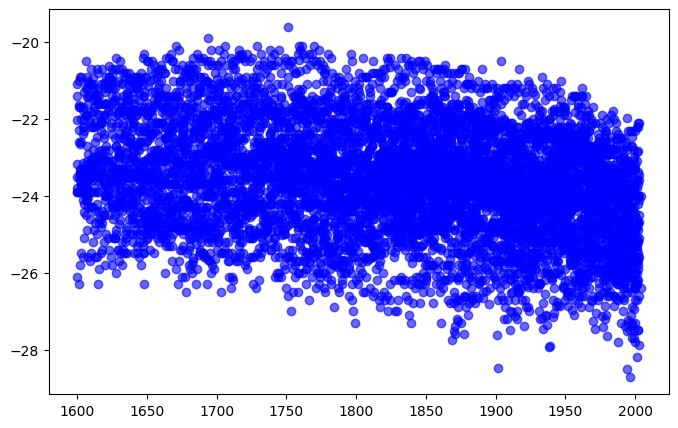

In [10]:
# Now using hat matrix
X = df_data_interpol['Year']
y = df_data_interpol['Value']

# Añadir intercepto
X1 = np.column_stack([np.ones(X.shape[0]), X])

# Calcular beta con mínimos cuadrados
beta_hat, *_ = np.linalg.lstsq(X1, y, rcond=None)

# Calcular matriz sombrero H
H = X1 @ np.linalg.inv(X1.T @ X1) @ X1.T
leverages = np.diag(H)

# Regla práctica de corte
n, p = X1.shape
threshold = 2*p/n

# --- Visualización ---
plt.figure(figsize=(8,5))
plt.scatter(X, y, c="blue", alpha=0.6, label="Datos")
plt.plot(X, X1 @ beta_hat, c="red", label="Recta ajustada")

# Resaltar puntos con leverage alto
outliers = leverages > threshold

### Using normal assumption on interpolated data to check for changes

In [11]:
# Visualize values in all sites
px.histogram(df_data_interpol, x='Value', title='Distribution of Values', nbins=60).show()

# Do Anderson darling test to see if the data matches normal distribution
result = anderson(df_data_interpol['Value'].dropna(), dist='norm' )
print('Result :', result)

# Once normal distribution can be associated standarize value to check for possible outliers
df_data_interpol['standarized_value'] = (df_data_interpol.Value - df_data_interpol.Value.mean()) / df_data_interpol.Value.std(ddof=0)

# Show outliers
display(df_data_interpol[df_data_interpol.standarized_value.abs() > 3])

# plot standarized values
px.histogram(df_data_interpol, x='standarized_value', title='Distribution of Values', nbins=60).show()


Result : AndersonResult(statistic=np.float64(3.400867258021208), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(-23.64295089581951), scale=np.float64(1.4394159846229098))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


,site_code,Year,Value,standarized_value
4454,LOC,1994,-28.50,-3.374543
4461,LOC,2001,-28.20,-3.166112
4768,NIE1,1902,-28.47,-3.353700
4862,NIE1,1996,-28.71,-3.520445


# Check for homogenity in data

### Globally

In [12]:
px.scatter(df_data_interpol, x='Year', y='Value', color='site_code').show()

### By tree species and location

In [22]:
df_data_interpol_species = df_data_interpol.merge(df_loc[['site_code', 'Species']],
                                                  on='site_code',
                                                  how='left')

# Lista de especies únicas
species_list = list(df_data_interpol_species['Species'].unique())

# Crear subplots con 3 filas y 2 columnas
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=[f"Species: {sp}" for sp in species_list]
)

# Iterar sobre especies
for idx, sp in enumerate(species_list):
    aux = df_data_interpol_species[df_data_interpol_species['Species'] == sp].reset_index(drop=True)
    
    # Calcular fila y columna
    row = idx // 2 + 1
    col = idx % 2 + 1
    
    # Agregar scatter por cada sitio dentro de la especie
    for site in aux['site_code'].unique():
        site_aux = aux[aux['site_code'] == site]
        fig.add_trace(
            go.Scatter(
                x=site_aux['Year'], y=site_aux['Value'],
                mode='markers',
                name=f"{sp} - {site}",
                
            ),
            row=row, col=col
        )

# Ajustar layout
fig.update_layout(
    title_text="Homogeneidad entre especies",
    height=1600, width=1600
)

fig.show()


# Standarization

In [23]:
# Standarization of SER and POE Site codes
df_caz = df_data[(df_data['site_code'] == 'CAZ') & (df_data['Value'].notna())].reset_index(drop=True)
df_caz['min_max'] = (df_caz['Value'] - df_caz['Value'].min()) / (df_caz['Value'].max() - df_caz['Value'].min())
df_caz['z_score'] = (df_caz['Value'] - df_caz['Value'].mean()) / df_caz['Value'].std(ddof=0)

df_poe = df_data[(df_data['site_code'] == 'POE') & (df_data['Value'].notna())].reset_index(drop=True)
df_poe['min_max'] = (df_poe['Value'] - df_poe['Value'].min()) / (df_poe['Value'].max() - df_poe['Value'].min())
df_poe['z_score'] = (df_poe['Value'] - df_poe['Value'].mean()) / df_poe['Value'].std(ddof=0)

df_caz

,site_code,Year,Value,standarized_value,min_max,z_score
0,CAZ,1600,-21.1,1.637860,0.680851,-0.081777
1,CAZ,1601,-21.0,1.704713,0.702128,0.080568
2,CAZ,1602,-20.9,1.771567,0.723404,0.242913
3,CAZ,1603,-20.9,1.771567,0.723404,0.242913
4,CAZ,1604,-21.7,1.236736,0.553191,-1.055845
...,...,...,...,...,...,...
398,CAZ,1998,-22.3,0.835612,0.425532,-2.029913
399,CAZ,1999,-22.8,0.501343,0.319149,-2.841637
400,CAZ,2000,-22.3,0.835612,0.425532,-2.029913
401,CAZ,2001,-22.2,0.902466,0.446809,-1.867569


In [24]:
import matplotlib.pyplot as plt

# Combine data for plotting
df_combined = pd.concat([df_caz, df_poe], ignore_index=True)

# Melt the DataFrame to long format for plotly
df_long_mm = df_combined.melt(id_vars=['site_code'], value_vars=['min_max'],
                           var_name='Standardization', value_name='Standardized_Value')

# Create boxplot
fig = px.box(df_long_mm, x='site_code', y='Standardized_Value',
             title='Min-Max standardization Boxplot for CAZ and POE',)
fig.show()

In [25]:
# Melt the DataFrame to long format for plotly
df_long_z = df_combined.melt(id_vars=['site_code'], value_vars=['z_score'],
                           var_name='Standardization', value_name='Standardized_Value')

# Create boxplot
fig = px.box(df_long_z, x='site_code', y='Standardized_Value',
             title='Z-score standardization Boxplot for CAZ and POE',)
fig.show()

In [26]:
fig = px.scatter(
    df_combined,
    x='Year',
    y='Value',
    color='site_code',
    title='Scatter plot for CAZ and POE'
)
fig.show()

In [28]:
df_caz

,site_code,Year,Value,standarized_value,min_max,z_score
0,CAZ,1600,-21.1,1.637860,0.680851,-0.081777
1,CAZ,1601,-21.0,1.704713,0.702128,0.080568
2,CAZ,1602,-20.9,1.771567,0.723404,0.242913
3,CAZ,1603,-20.9,1.771567,0.723404,0.242913
4,CAZ,1604,-21.7,1.236736,0.553191,-1.055845
...,...,...,...,...,...,...
398,CAZ,1998,-22.3,0.835612,0.425532,-2.029913
399,CAZ,1999,-22.8,0.501343,0.319149,-2.841637
400,CAZ,2000,-22.3,0.835612,0.425532,-2.029913
401,CAZ,2001,-22.2,0.902466,0.446809,-1.867569


In [30]:
# Merge por año
df_merge = pd.merge(
    df_caz[['Year', 'Value']],
    df_poe[['Year', 'Value']],
    on='Year',
    how='outer',
    suffixes=('_CAZ', '_POE')
)

# Scatter plot
fig = px.scatter(
    df_merge,
    x='Value_CAZ',
    y='Value_POE',
    title='POE vs CAZ by year',
    labels={'Value_CAZ': 'CAZ Value', 'Value_POE': 'POE Value'}
)
fig.show()

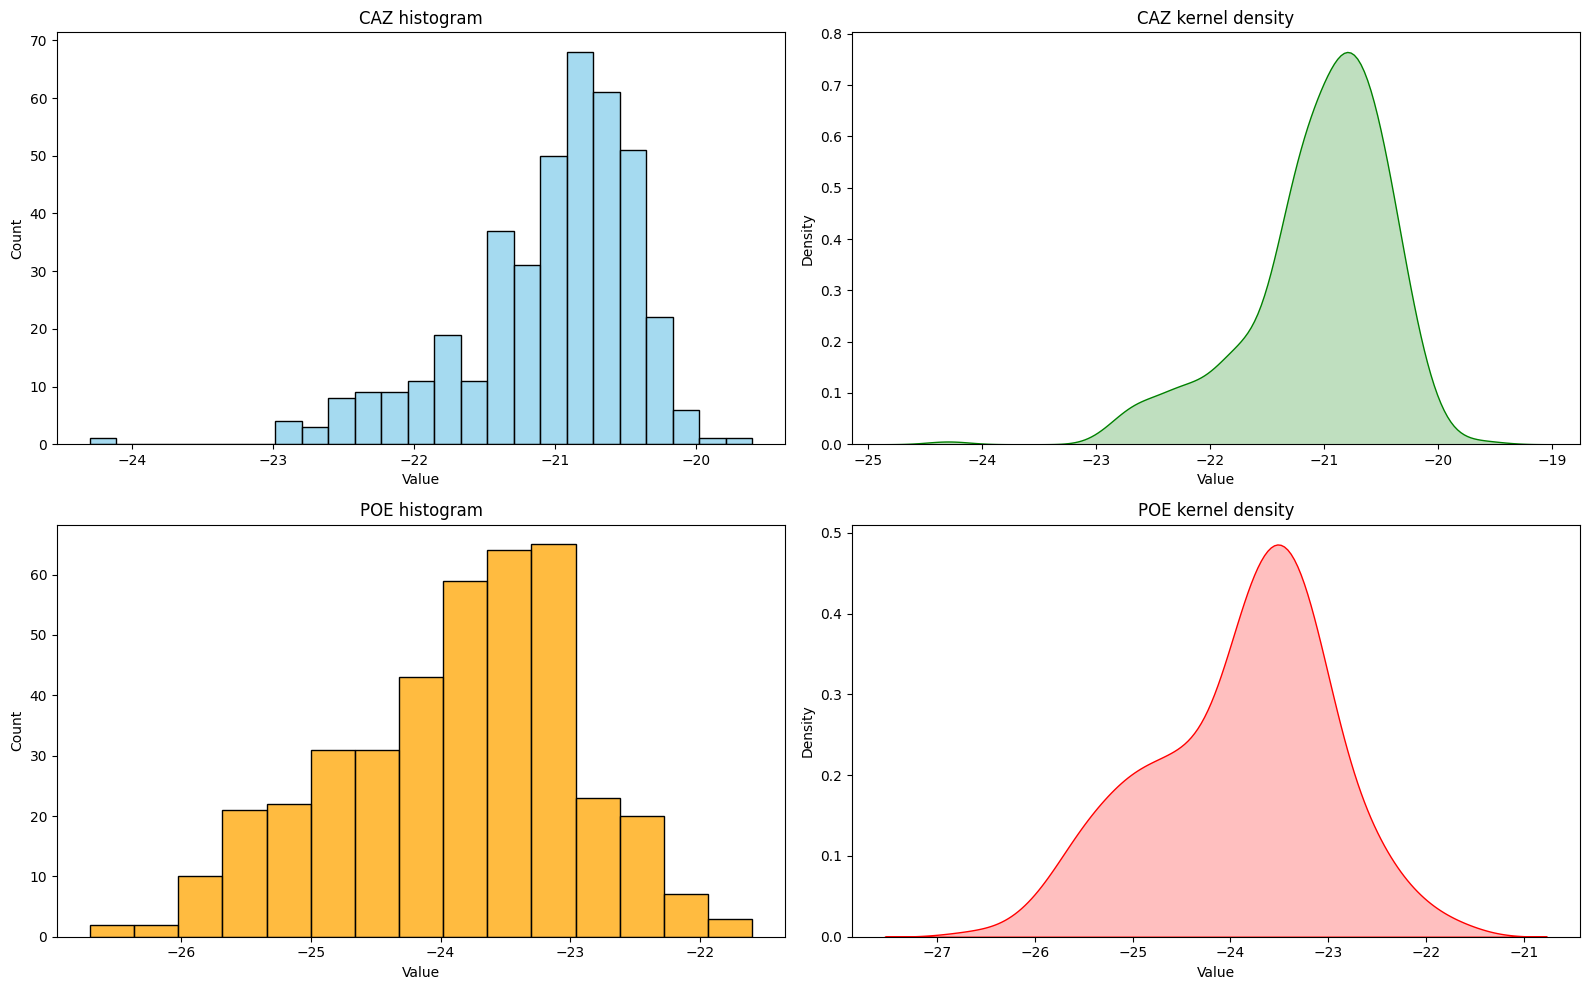

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Gráfica compuesta ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histograma CAZ
sns.histplot(df_caz['Value'].dropna(), kde=False, ax=axes[0, 0], color="skyblue")
axes[0, 0].set_title(f"CAZ histogram")
# Densidad kernel CAZ
sns.kdeplot(df_caz['Value'].dropna(), ax=axes[0, 1], color="green", fill=True)
axes[0, 1].set_title(f"CAZ kernel density")  

# Histograma POE
sns.histplot(df_poe['Value'].dropna(), kde=False, ax=axes[1, 0], color="orange")
axes[1, 0].set_title(f"POE histogram")
# Densidad kernel POE
sns.kdeplot(df_poe['Value'].dropna(), ax=axes[1, 1], color="red", fill=True)
axes[1, 1].set_title(f"POE kernel density")
    

plt.tight_layout()
plt.show()


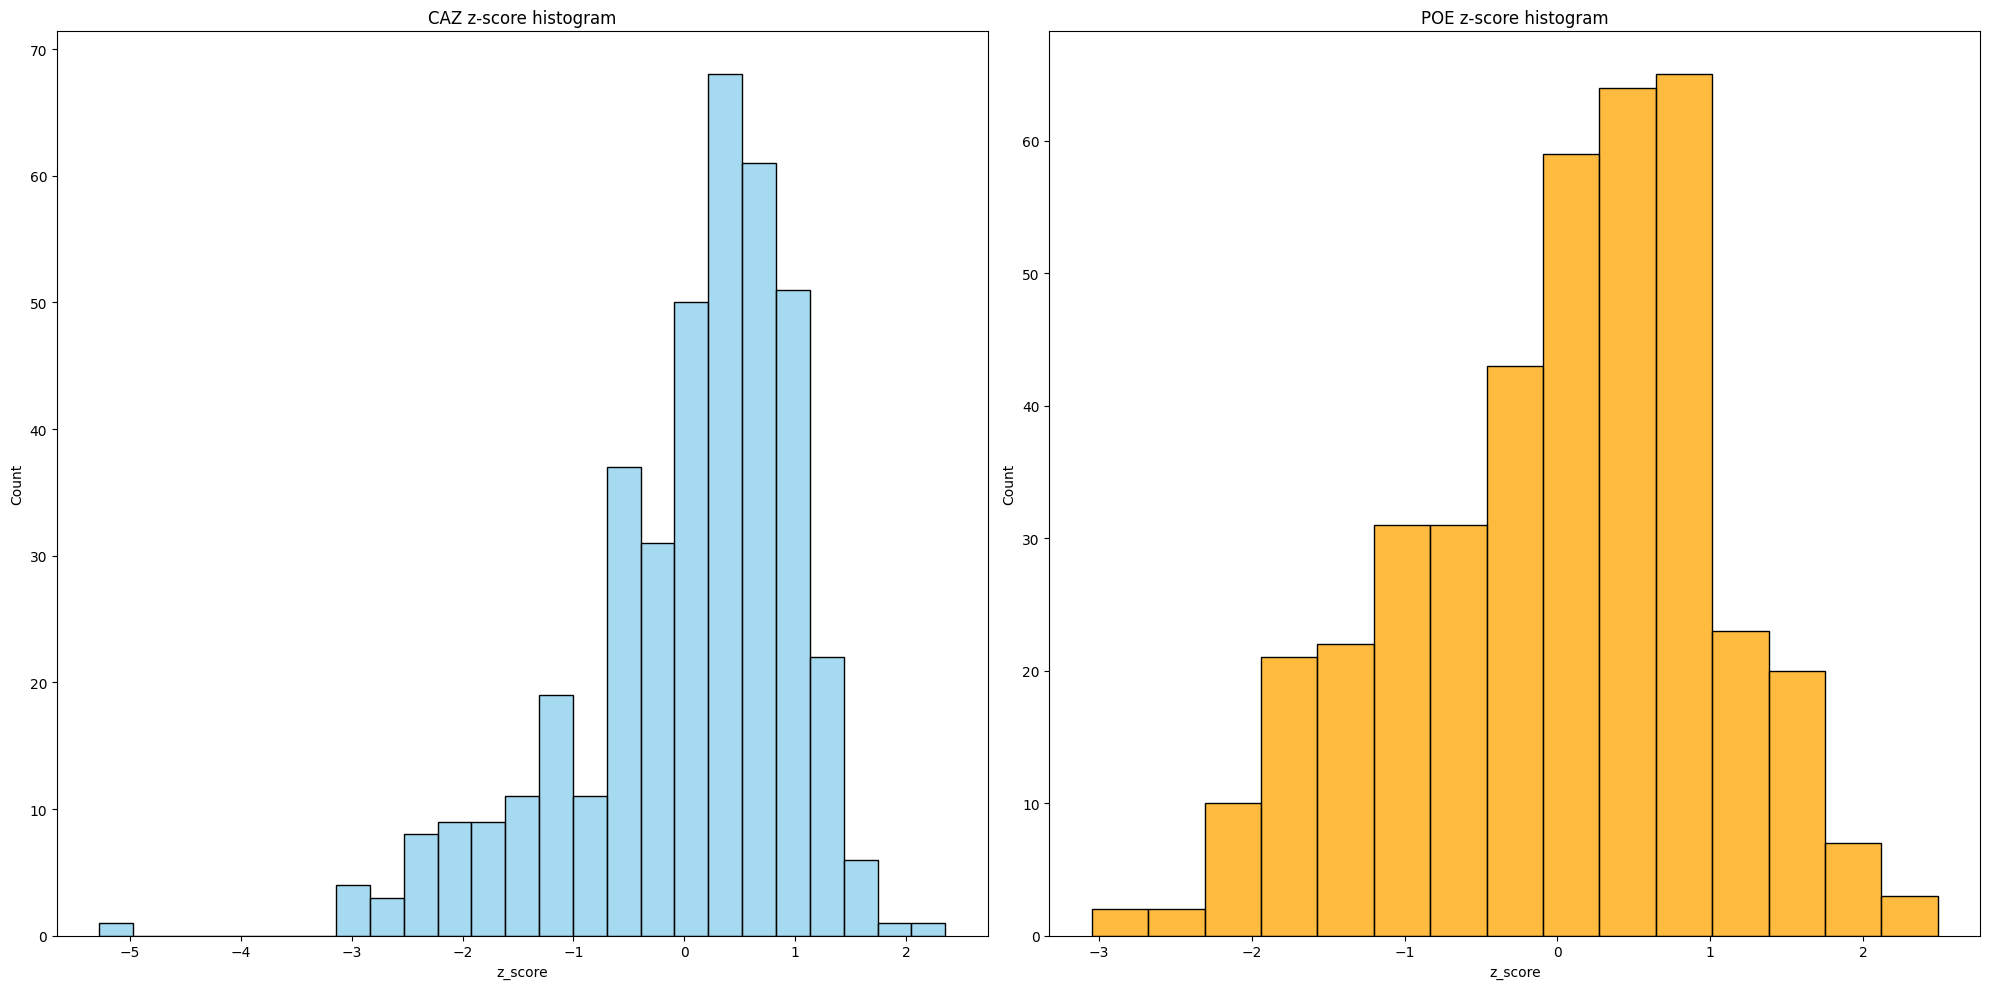

In [32]:
# --- Gráfica compuesta ---
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Histograma CAZ z-score
sns.histplot(df_caz['z_score'].dropna(), kde=False, ax=axes[0], color="skyblue")
axes[0].set_title(f"CAZ z-score histogram")

# Histograma POE z-score
sns.histplot(df_poe['z_score'].dropna(), kde=False, ax=axes[1], color="orange")
axes[1].set_title(f"POE z-score histogram")

plt.tight_layout()
plt.show()